In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use('MNRAS')

In [2]:
zh_min_list = [0.2, 0.35, 0.5]
zh_max_list = [0.35, 0.5, 0.65]
lambda_min_list = [5, 10, 14, 20, 30, 45, 60]
lambda_max_list = [10, 14, 20, 30, 45, 60, 1000]
nz = len(zh_min_list)
nlam = len(lambda_min_list)

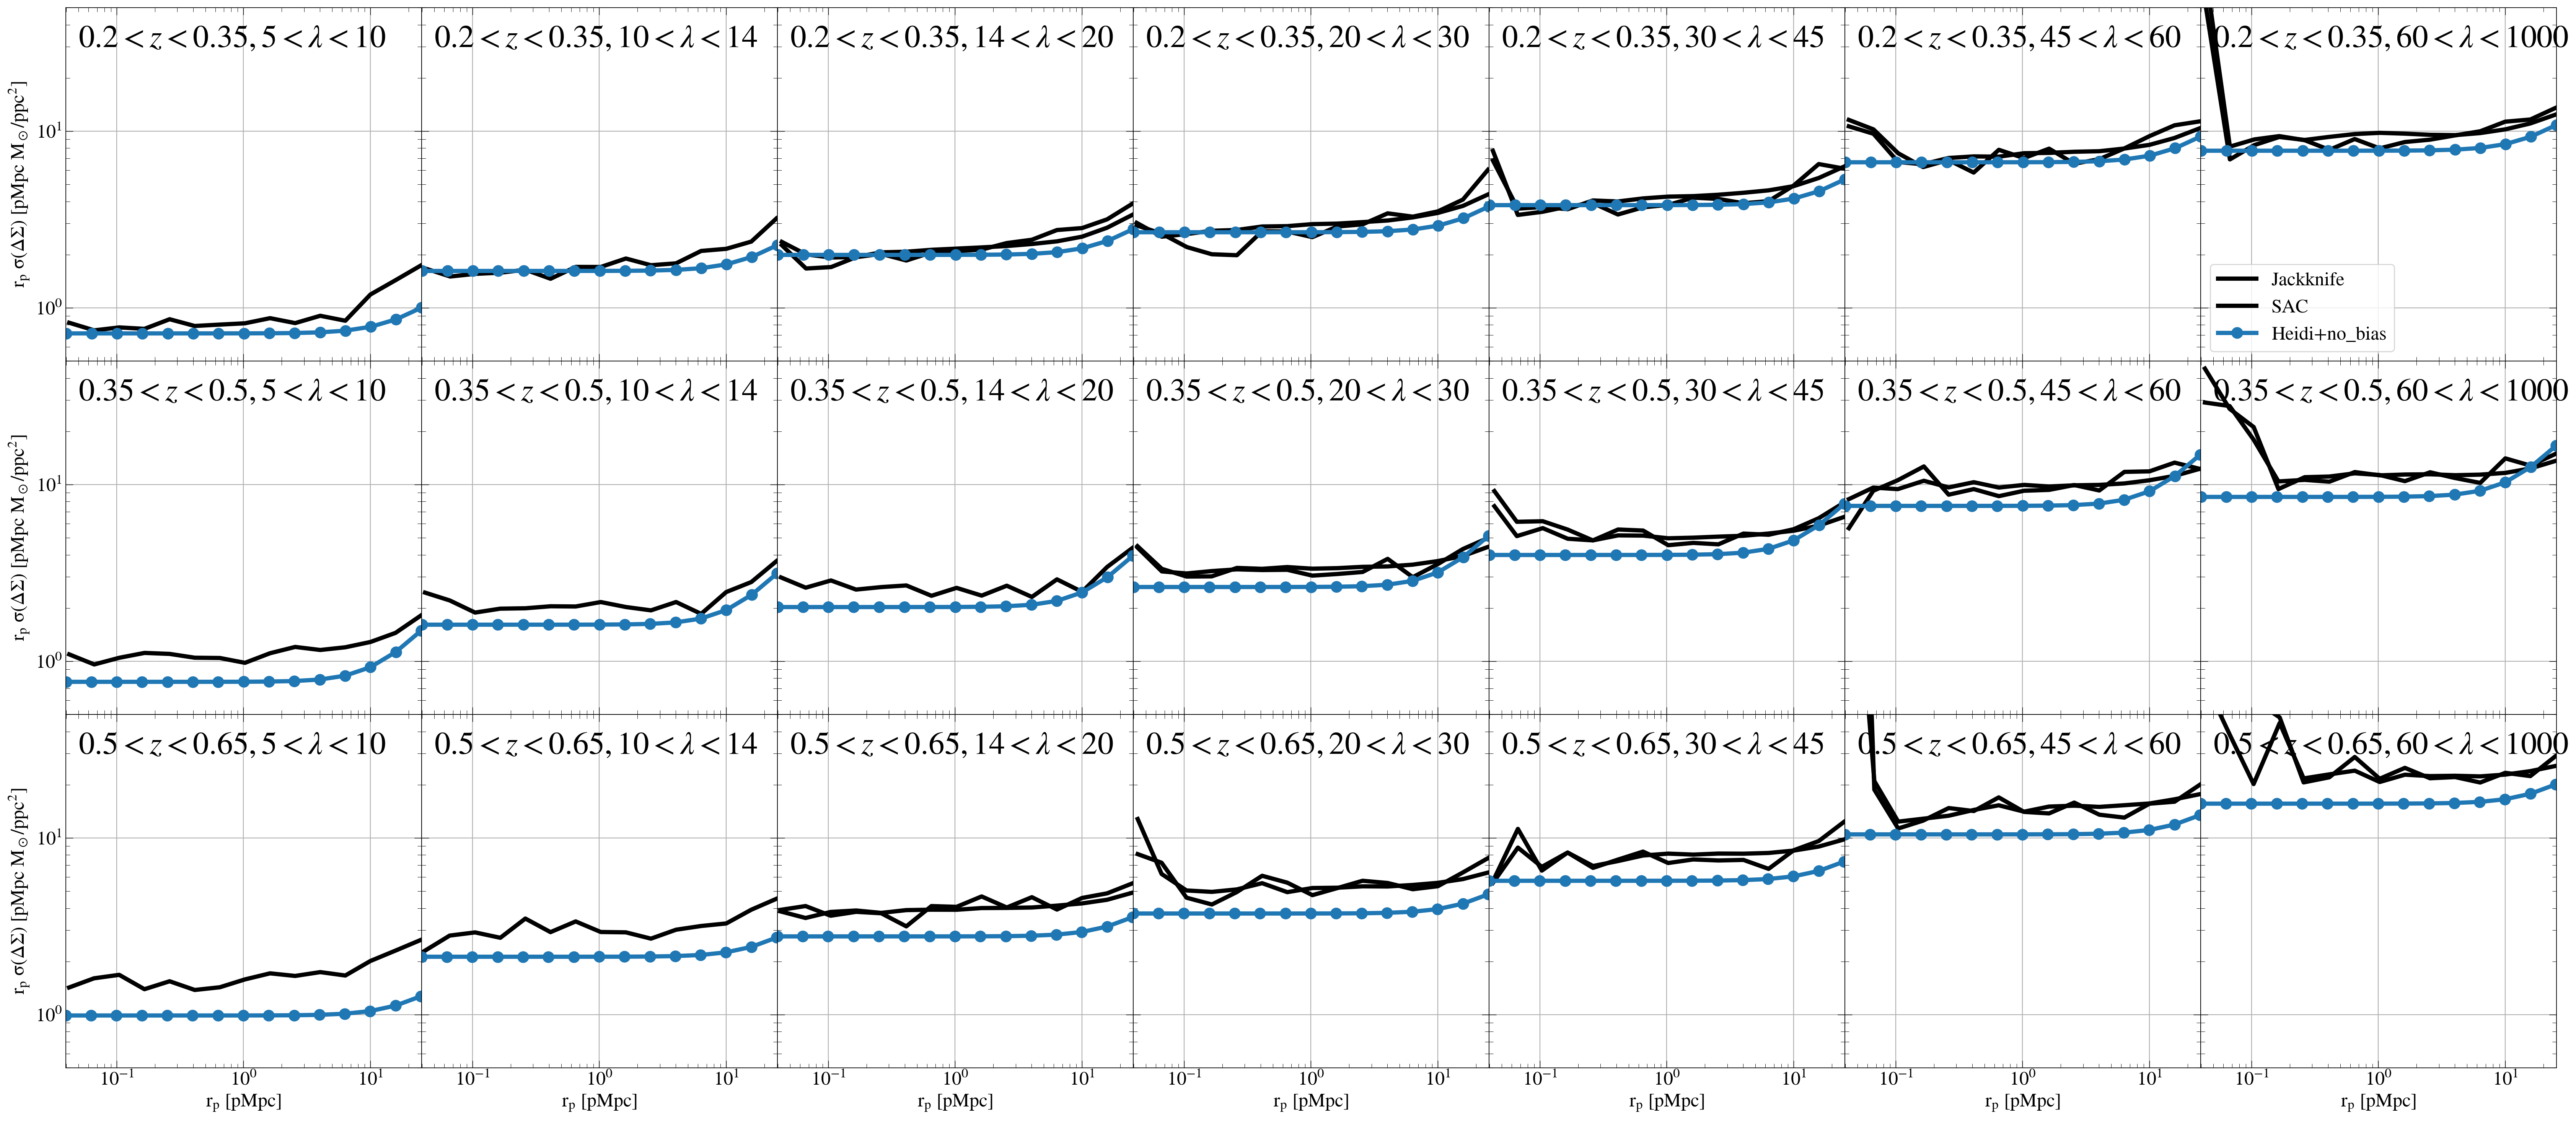

In [3]:
fig, axes = plt.subplots(nz, nlam, sharex=True, sharey=True, figsize=(6*nlam, 6*nz), gridspec_kw = {'wspace':0, 'hspace':0})
for iz in range(nz):
    for ilam in range(nlam):
        ax = axes[iz,ilam]

        # Tamas's Jackknife  # ilam starts from lambda = 5
        loc = '../data/desy1_jackknife/'
        fname = loc + f'full-unblind-v2-mcal-zmix_y1subtr_l{ilam}_z{iz}_profile.dat'
        if os.path.exists(fname):
            data = np.loadtxt(fname)
            rp_y1 = data[:,0]
            DS_y1 = data[:,1]
            dDS_y1 = data[:,2]
            ax.loglog(rp_y1, rp_y1*dDS_y1, label='Jackknife', lw=4, c='k')
        
        # Tom's SAC
        loc = '../data/desy1_SAC/'
        fname = loc + f'SAC_z{iz}_l{ilam}.txt'
        if os.path.exists(fname):
            cov = np.loadtxt(fname)
            dDS = np.sqrt(np.diag(cov))
            ax.loglog(rp_y1, rp_y1*dDS, '-', label='SAC', lw=4, markersize=20, c='k')

        # my analytic        
        zh_min = zh_min_list[iz]
        zh_max = zh_max_list[iz]
        lambda_min = lambda_min_list[ilam]
        lambda_max = lambda_max_list[ilam]
        bin_name = f'{zh_min}_{zh_max}_{lambda_min}_{lambda_max}'
            
        for MOR in ['no_bias']:#, 'no_bias_1dndz']:#['To21', 'counts_bias']:
            loc = f'desy1_analytic_{MOR}/'
            fname = loc+f'rp_phys_noh_{bin_name}.dat'
            if os.path.exists(fname):
                rp = np.loadtxt(fname)#[:,2]
                #h = 0.7
                #zh_mid = 0.5 * (zh_min + zh_max)
                #a = 1 / (1+zh_mid)
                #rp = rp / h * a
        
                cov = np.loadtxt(loc+f'DeltaSigma_cov_combined_phys_noh_{bin_name}.dat') 
                #cov = np.loadtxt(loc+f'DeltaSigma_cov_shape_noise_{bin_name}.dat') 
                dDS = np.sqrt(np.diag(cov))
                #print(dDS)
                #dDS = dDS * h / a**2
                ax.plot(rp, rp*dDS, 'o-', label='Heidi+'+MOR, lw=4, markersize=10)#, c='k')

        
        label = r'$%g<z<%g, %g<\lambda<%g$'%(zh_min, zh_max, lambda_min, lambda_max)
        ax.text(0.05, 30, label, fontsize=30)        
        ax.loglog()
        ax.set_ylim(0.5, 50.)
        if iz == 0 and ilam == nlam-1:
            ax.legend(loc=3)
        if iz == 2:
            ax.set_xlabel(r'$\rm r_p ~ [pMpc]$')
        if ilam == 0:
            ax.set_ylabel(r'$\rm r_p ~ \sigma(\Delta\Sigma) ~ [pMpc ~ M_\odot / ppc^2]$')

#plt.savefig('cov_desy1.png')

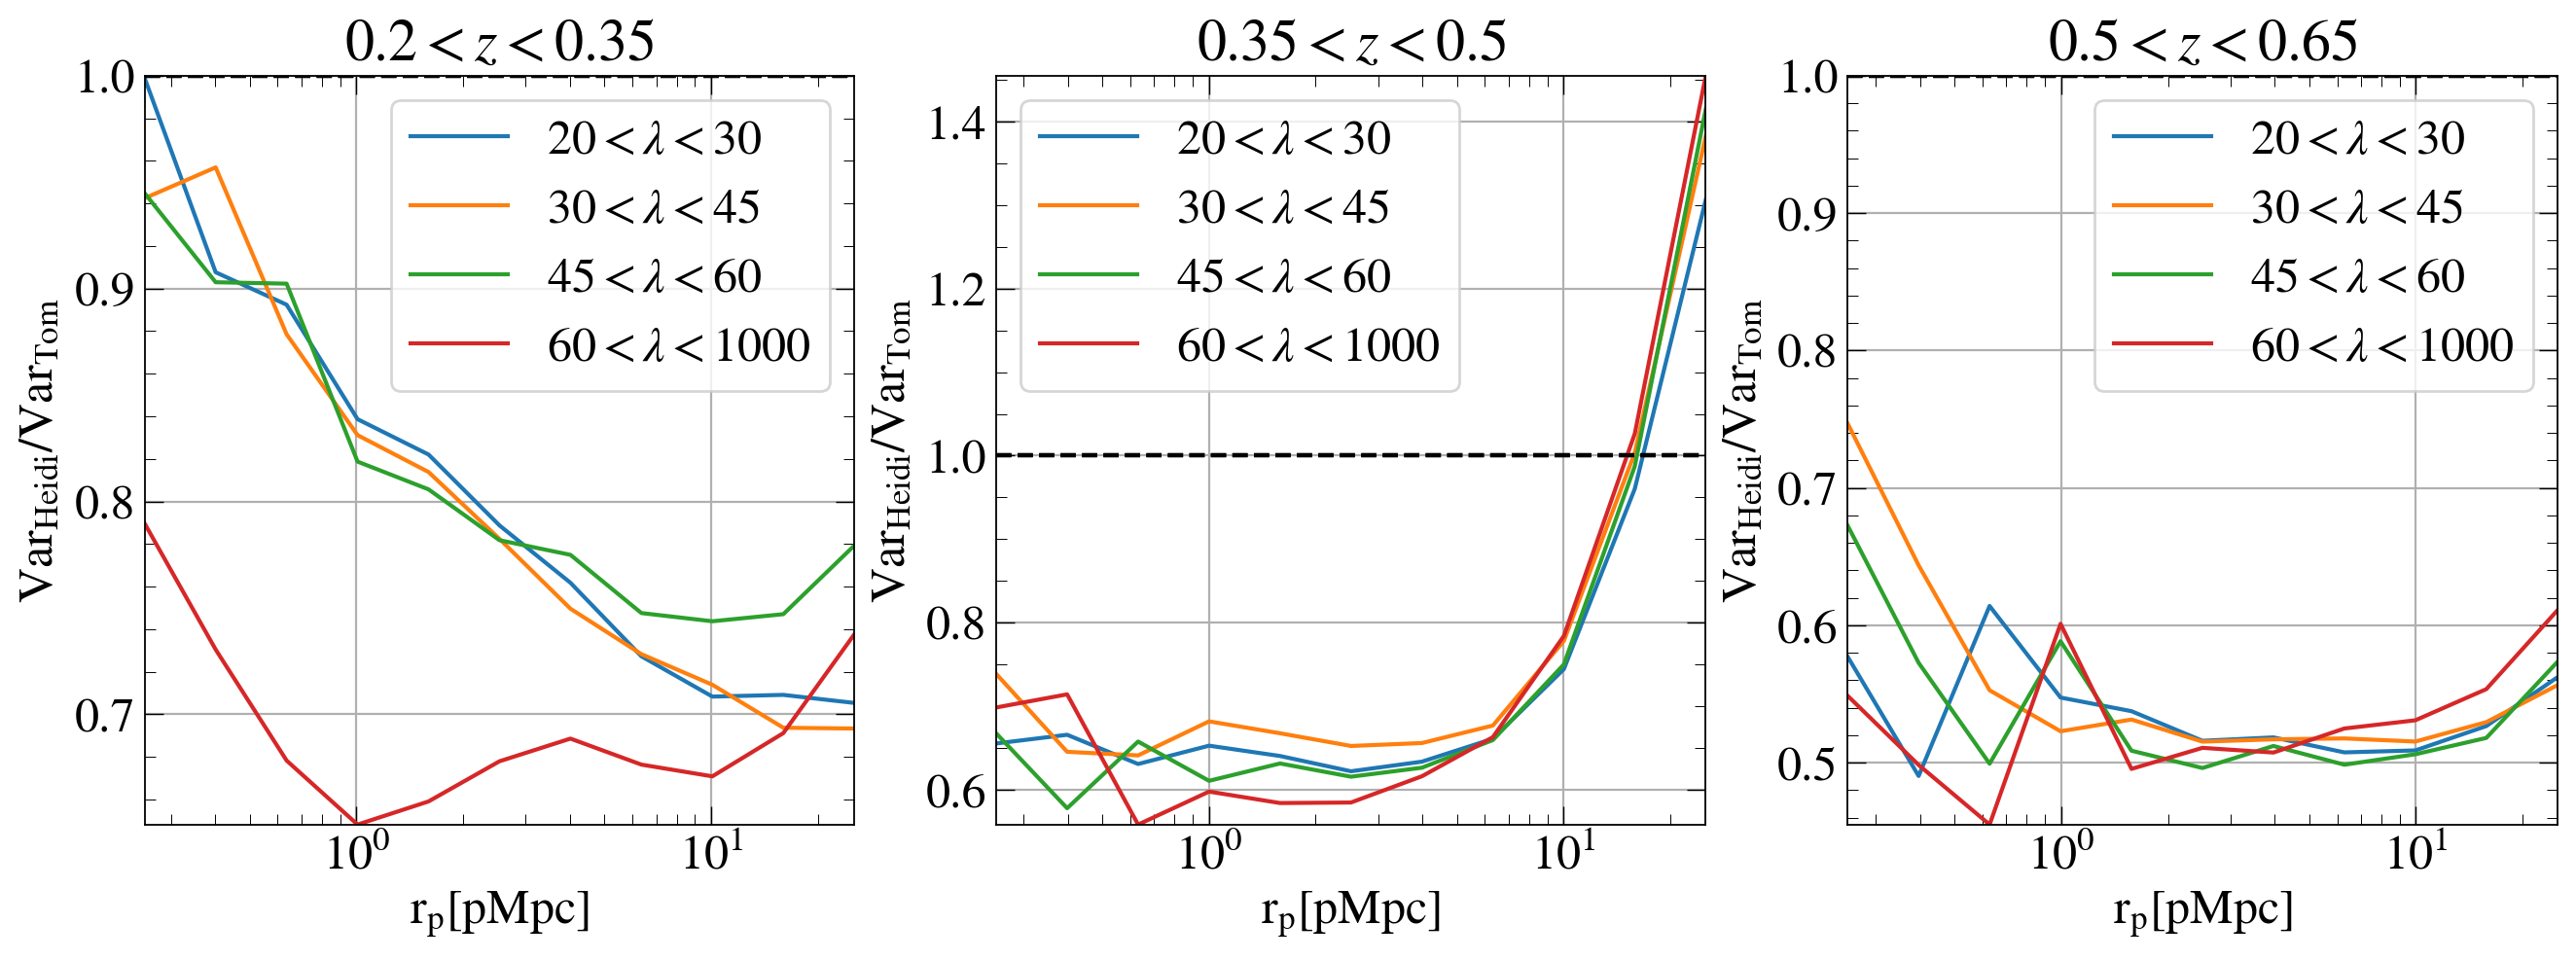

In [4]:
#### Plot the ratio
plt.figure(figsize=(16,5))
for iz in range(nz):
    plt.subplot(1, 3, iz+1)
    for ilam in range(3,nlam):
        # Tom's SAC
        loc = '../data/desy1_SAC/'
        fname = loc + f'SAC_z{iz}_l{ilam}.txt'
        if os.path.exists(fname):
            cov = np.loadtxt(fname)
            var_tom = np.diag(cov)
       
        # my analytic
        loc = f'desy1_analytic_no_bias/'
        zh_min = zh_min_list[iz]
        zh_max = zh_max_list[iz]

        lambda_min = lambda_min_list[ilam]
        lambda_max = lambda_max_list[ilam]
        
        bin_name = f'{zh_min}_{zh_max}_{lambda_min}_{lambda_max}'

        #### My prediction ####
        fname = loc+f'rp_phys_noh_{bin_name}.dat'
        if os.path.exists(fname):
            rp_heidi = np.loadtxt(fname)#[:,2]
            # h = 0.7
            # zh_mid = 0.5 * (zh_min + zh_max)
            # a = 1 / (1+zh_mid)
            #rp_heidi = rp / h * a
    
            cov = np.loadtxt(loc+f'DeltaSigma_cov_combined_phys_noh_{bin_name}.dat') 
            #cov = np.loadtxt(loc+f'DeltaSigma_cov_shape_noise_{bin_name}.dat') 
            var_heidi = np.diag(cov) #* h**2/a**4
            ratio = var_heidi / var_tom

            sel = rp_heidi > 0.2
            plt.plot(rp_heidi[sel], ratio[sel], label=r'$%g < \lambda < %g$'%(lambda_min, lambda_max))
            plt.xscale('log')
            plt.axhline(1, c='k', ls='--')
            plt.legend()
            plt.title(r'$%g<z<%g$'%(zh_min, zh_max))
 
    plt.ylabel(r'$\rm Var_{Heidi} / Var_{Tom}$')
    plt.xlabel(r'$\rm r_p [pMpc]$')
#plt.savefig('var_tom_vs_heidi.png')

/tmp/ipykernel_3607216/377514444.py:15: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(cov))


<Figure size 1240x1000 with 0 Axes>

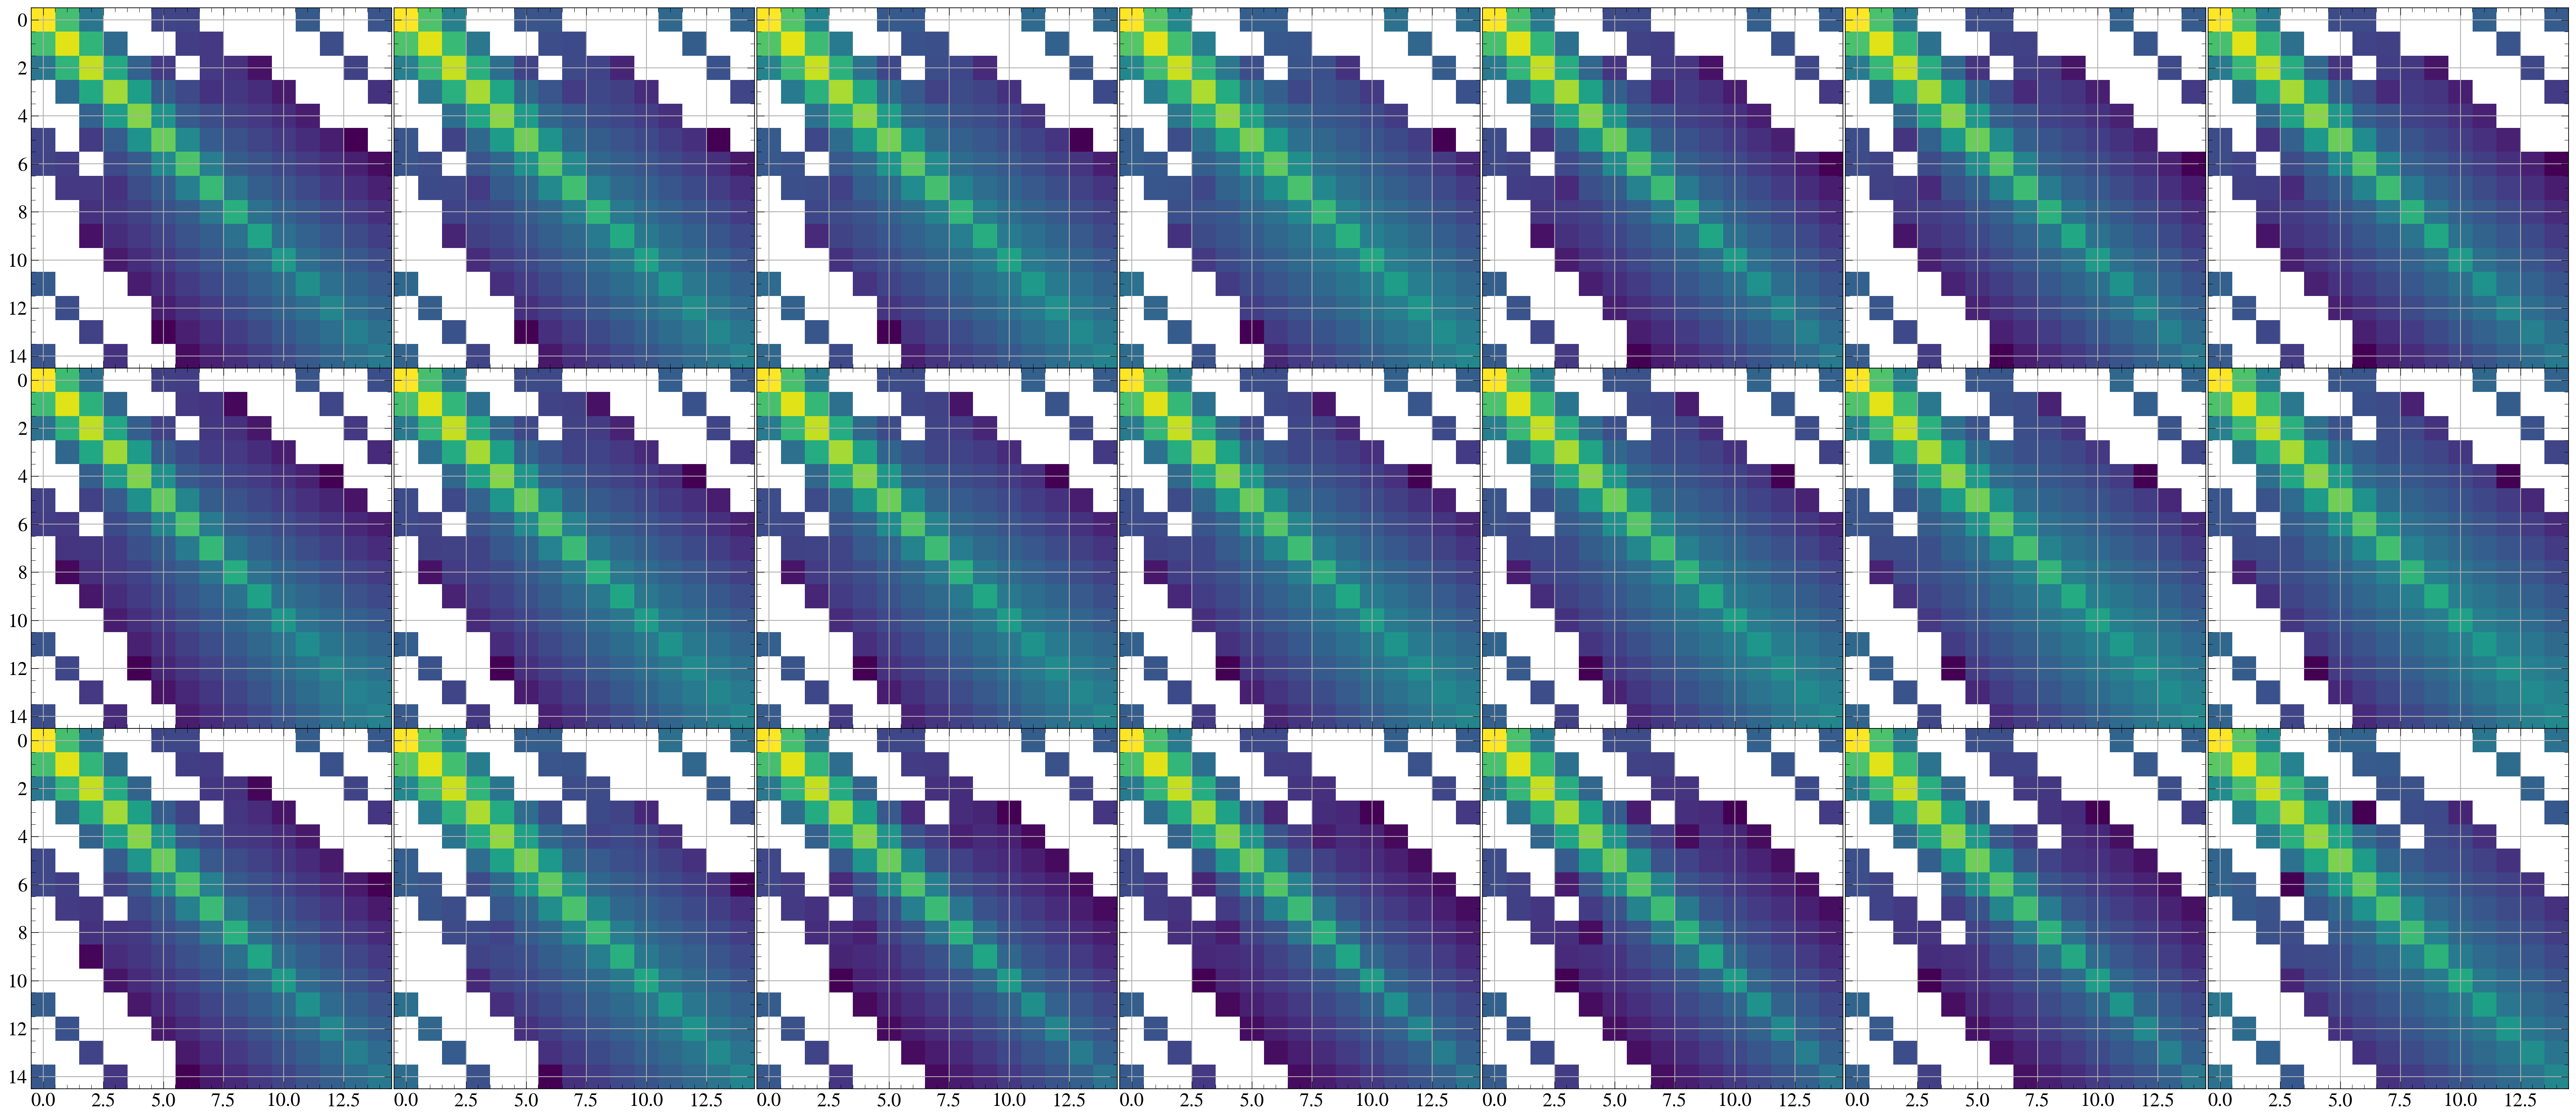

In [5]:
loc = f'desy1_analytic_To21/'
plt.figure()
fig, axes = plt.subplots(nz, nlam, sharex=True, sharey=True, figsize=(6*nlam, 6*nz),
                         gridspec_kw = {'wspace':0, 'hspace':0})
for iz in range(nz):
    for ilam in range(nlam):
        ax = axes[iz,ilam]
        zh_min = zh_min_list[iz]
        zh_max = zh_max_list[iz]
        lambda_min = lambda_min_list[ilam]
        lambda_max = lambda_max_list[ilam]
                    
        bin_name = f'{zh_min}_{zh_max}_{lambda_min}_{lambda_max}'
        cov = np.loadtxt(loc+f'DeltaSigma_cov_combined_{bin_name}.dat') 
        ax.imshow(np.log10(cov))

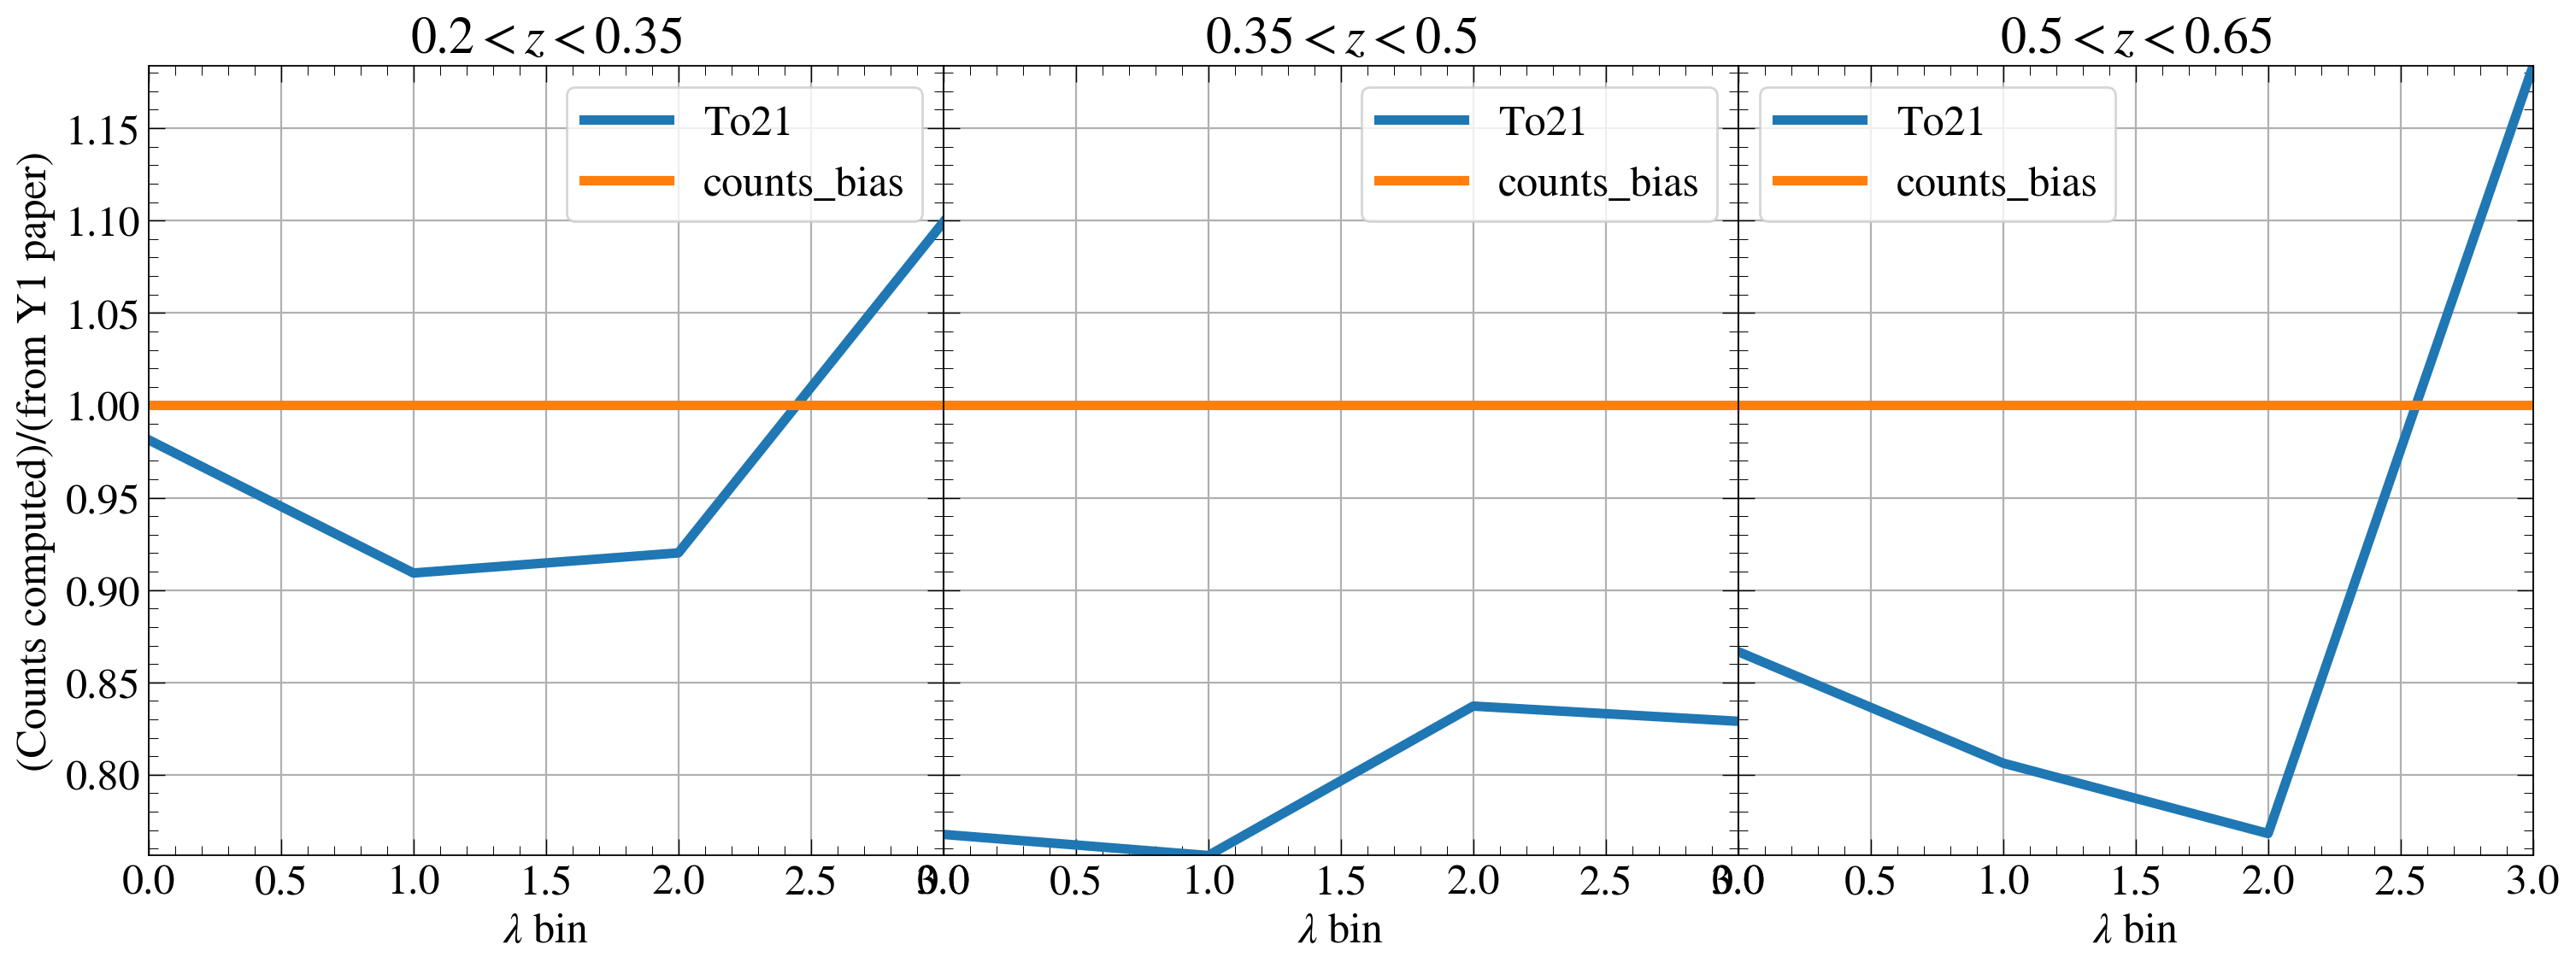

In [6]:
## not using the 2 low-lambda bins ###
zh_min_list = [0.2, 0.35, 0.5]
zh_max_list = [0.35, 0.5, 0.65]
lambda_min_list = [20, 30, 45, 60]
lambda_max_list = [30, 45, 60, 1000]

counts_y1 = np.array([[762, 376, 123, 91],
                     [1549, 672, 187, 148],
                     [1612, 687, 205, 92]])

counts_y1_corr = np.array([[785.1, 388.3, 127.2, 93.9],
                     [1596.0, 694.0, 193.4, 151.7],
                     [1660.9, 709.5, 212.0, 94.9]])

# compare number counts
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 6),
                         gridspec_kw = {'wspace':0, 'hspace':0})
for iz in range(3):
    ax = axes[iz]

    
    for MOR in ['To21', 'counts_bias']:
        counts_list = []
        for ilam in range(4):
            #### my analytic
        
            loc = f'desy1_analytic_{MOR}/'
            zh_min = zh_min_list[iz]
            zh_max = zh_max_list[iz]
    
            lambda_min = lambda_min_list[ilam]
            lambda_max = lambda_max_list[ilam]
    
            bin_name = f'{zh_min}_{zh_max}_{lambda_min}_{lambda_max}'
            counts = np.loadtxt(loc+f'counts_{bin_name}.dat')[0]
            counts_list.append(counts)

        ax.plot(np.arange(4), counts_list/counts_y1[iz], lw=4, label=MOR)

    
    ax.set_title(r'$%g<z<%g$'%(zh_min,zh_max))

    #ax.plot(np.arange(4), counts_y1[iz], ':x', label='y1', markersize=20)
    #ax.plot(np.arange(4), counts_y1_corr[iz], '--', label='y1 corrected')
    ax.legend()
    
    #ax.set_yscale('log')
    ax.set_xlabel(r'$\lambda$ bin')
    if iz == 0:
        ax.set_ylabel(r'(Counts computed)/(from Y1 paper)')
    

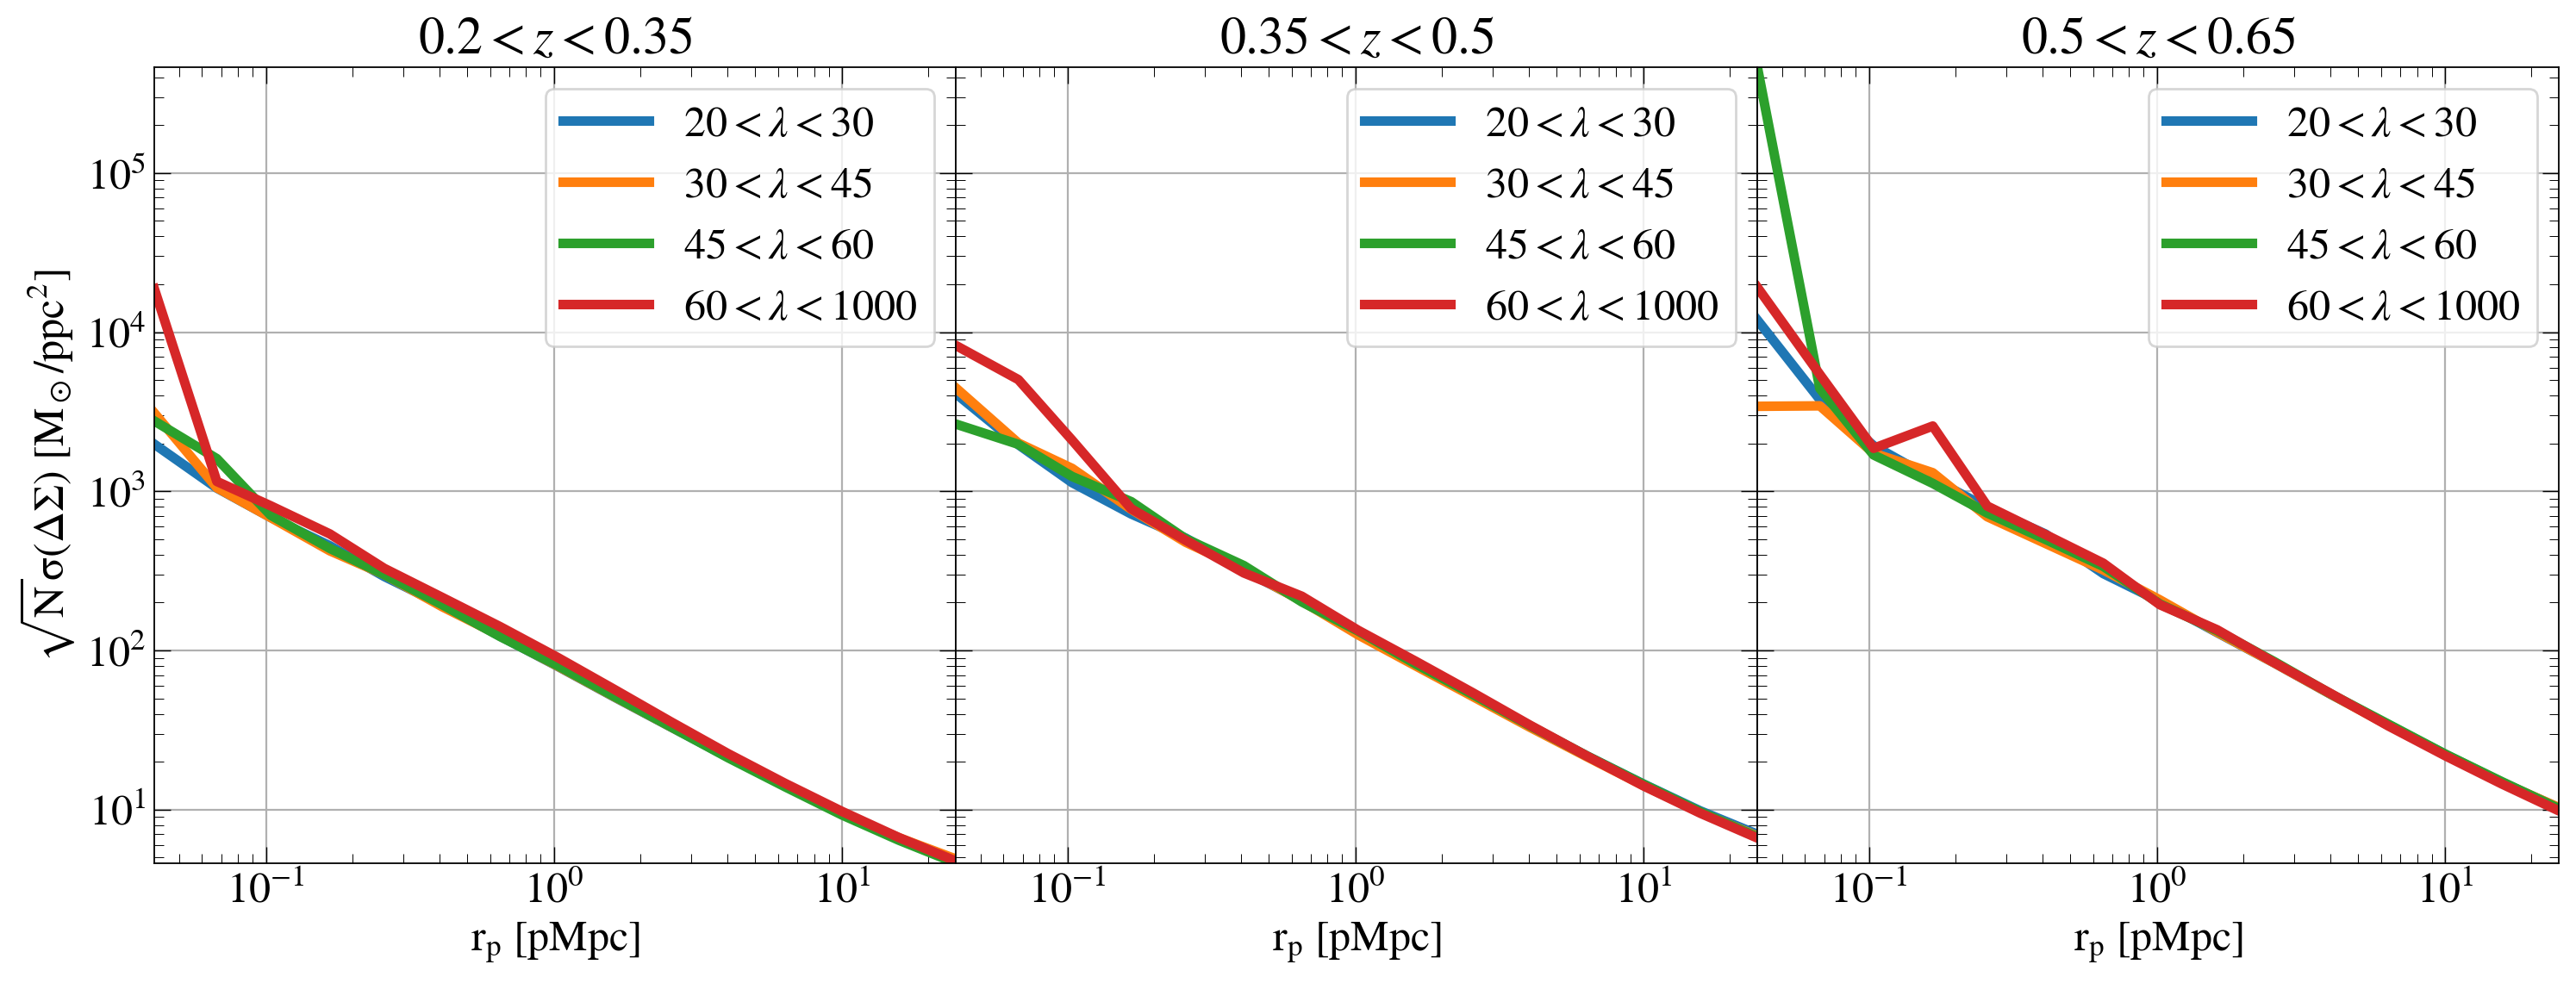

In [8]:
# plot cov * Ncl
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18, 6),
                         gridspec_kw = {'wspace':0, 'hspace':0})

#ax = plt.gca()
    
zh_min_list = [0.2, 0.35, 0.5]
zh_max_list = [0.35, 0.5, 0.65]
lambda_min_list = [20, 30, 45, 60]
lambda_max_list = [30, 45, 60, 1000]
#plt.suptitile('SAC')

for iz in range(3):
    for ilam in range(4):
        ax = axes[iz]#,ilam]

        zh_min = zh_min_list[iz]
        zh_max = zh_max_list[iz]
        lambda_min = lambda_min_list[ilam]
        lambda_max = lambda_max_list[ilam]

        # reading Tom's SAC
        loc = '../data/desy1_SAC/'
        fname = loc + f'SAC_z{iz}_l{3+ilam}.txt'
        cov = np.loadtxt(fname)
        dDS = np.sqrt(np.diag(cov))
        NC = counts_y1[iz, ilam]
        ax.loglog(rp_y1, dDS*np.sqrt(NC), lw=4, 
                  label=r'$%g < \lambda <%g$'%(lambda_min,lambda_max))

        ax.set_title(r'$%g<z<%g$'%(zh_min,zh_max))
        ax.legend(loc=1)
        
        ax.set_xlabel(r'$\rm r_p ~ [pMpc]$')
        if iz == 0:
            ax.set_ylabel(r'$\rm \sqrt{N}\sigma(\Delta\Sigma) ~ [M_\odot / ppc^2]$')